In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import matthews_corrcoef
import category_encoders as ce
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt

In [2]:
heart = pd.read_csv('data/heart.zip')
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
heart.slope.value_counts()

2    142
1    140
0     21
Name: slope, dtype: int64

age — возраст

sex — пол (1 - мужчина, 0 - женщина)

cp — тип боли в груди (4 значения)

trestbps — артериальное давление в покое

chol — холестерин сыворотки в мг/дл

fbs — уровень сахара в крови натощак > 120 мг/дл

restecg — результаты электрокардиографии в покое (значения 0,1,2)

thalach — достигнута максимальная частота сердечных сокращений

exang — стенокардия, вызванная физической нагрузкой

oldpeak — депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя

slope — наклон пикового сегмента ST при нагрузке

ca — количество крупных сосудов (0-3), окрашенных при флюроскопии

thal — дефект, где 3 = нормальный; 6 = фиксированный дефект; 7 = обратимый дефект

### 8.1. Создайте новый признак old, где 1 — при возрасте пациента более 60 лет

In [4]:
heart['old'] = heart.age.apply(lambda x: 1 if x > 60 else 0)
print(f'{heart.old.sum()} пациентов старше 60 лет')

79 пациентов старше 60 лет


### 8.2. Создайте новый признак trestbps_mean, который будет обозначать норму давления в среднем для его возраста и пола

In [7]:
def get_trestbps_mean (row):
    trestbps_man = {20: 123, 30: 126, 40: 129, 50: 135, 60: 142, 200: 142}
    trestbps_woman = {20: 116, 30: 120, 40: 127, 50: 137, 60: 144, 200: 159}
    if row['sex'] == 1:
        trestbps_dict = trestbps_man
    else:
        trestbps_dict = trestbps_woman
    for i, j in trestbps_dict.items():
        if row['age'] <= i:
            return j
    
    
heart['trestbps_mean'] = heart.apply(get_trestbps_mean, axis=1)

In [8]:
heart

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,old,trestbps_mean
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,1,142
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0,129
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,137
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0,142
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0,0,144
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0,0,135
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,1,142
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0,0,142


### 8.5. Закодируйте вышеперечисленные признаки методом OneHotEncoding без удаления исходных признаков

In [9]:
code_col = ['cp', 'restecg', 'slope', 'ca', 'thal']
encoder = ce.OneHotEncoder(cols=code_col)
heart_code = encoder.fit_transform(heart[code_col])
new_heart = pd.concat([heart, heart_code], axis=1)

print(new_heart.shape[1])

35


### 8.6. Нормализуйте все числовые признаки подходящим способом

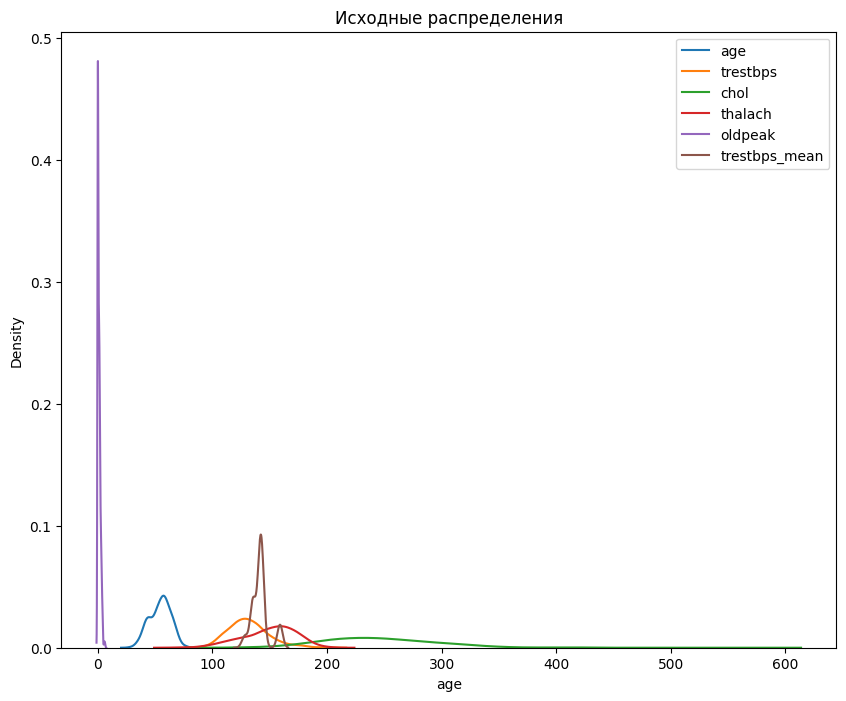

In [10]:
num_col = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'trestbps_mean']
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
for col in num_col:
       sns.kdeplot(heart[col], ax=ax1, label =col)

plt.legend();

Стандартное отклонение признака chol равно 0.816232


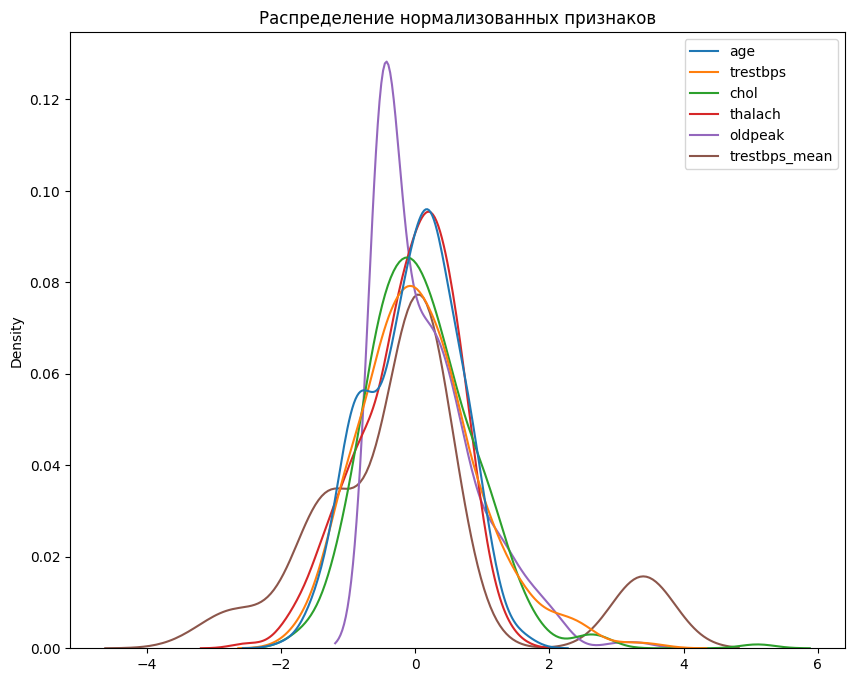

In [11]:
r_sc = preprocessing.RobustScaler()
new_heart[num_col] = r_sc.fit_transform(new_heart[num_col])

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределение нормализованных признаков')

sns.kdeplot(new_heart[num_col], ax=ax1);
std_chol = round(new_heart.chol.describe()['std'], 6)
print(f'Стандартное отклонение признака chol равно {std_chol}')

### 8.7. Проведите корреляционный анализ и отберите признаки для будущей модели

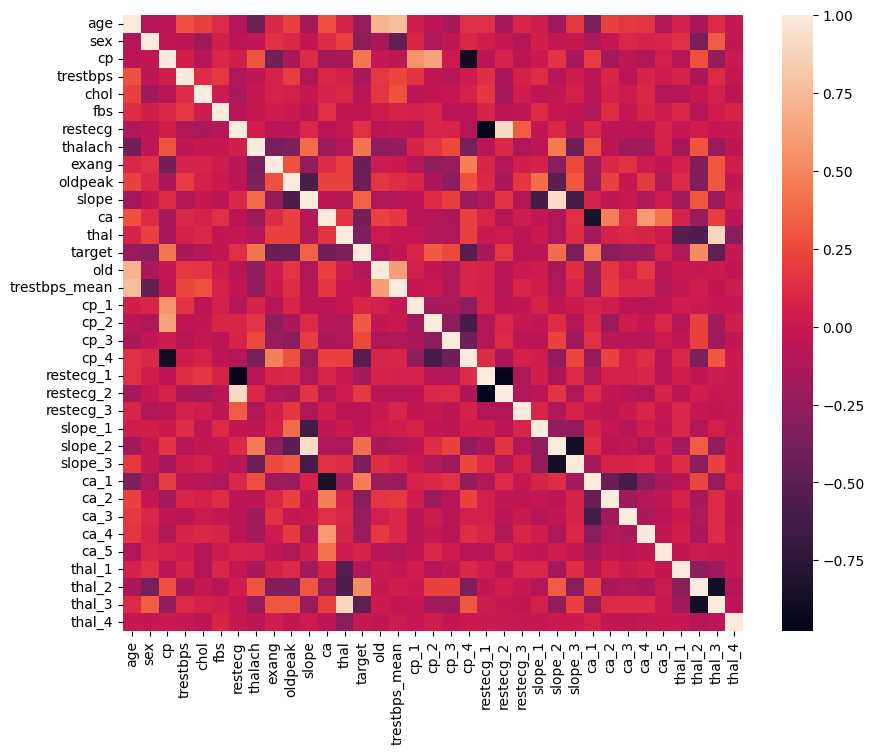

In [12]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
sns.heatmap(new_heart.corr(numeric_only=True));

In [14]:
extra_signs = ['thal_3', 'restecg_2', 'slope_2', 'ca_4', 'cp_2']
new_heart_corr = new_heart.drop(extra_signs, axis=1)

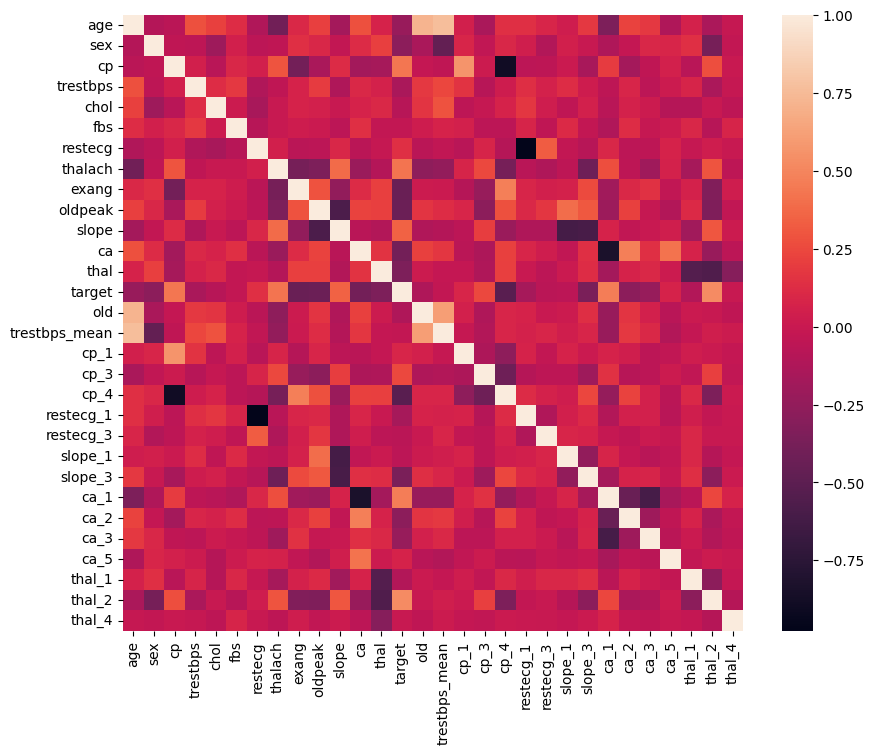

In [15]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
sns.heatmap(new_heart_corr.corr(numeric_only=True));